In [1]:
import matplotlib.pyplot as plt
import kwant
import numpy as np
import scipy
import scipy.ndimage
import scipy.linalg as la
from types import SimpleNamespace
%matplotlib inline

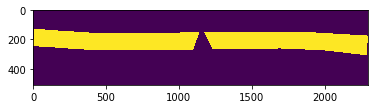

In [2]:
#designfile = '/users/tkm/kanilmaz/thesis/designfiles/hb_lower_part.png'
designfile = '/home/nefta/thesis/designfiles/qpc.png'
topgate = 1 - scipy.ndimage.imread(designfile, mode='L').T / 255
decay = 0
topgate_gauss = scipy.ndimage.gaussian_filter(topgate, decay)
plt.imshow(topgate_gauss)
#topgate = np.zeros((10, 5))

In [3]:
#scipy.ndimage.imread(
#    '/users/tkm/kanilmaz/thesis/designfiles/scatteringRegion_sleeves.png')

In [4]:
#scattering_region = np.ones(topgate_gauss.shape)
#scattering_region = 1 - scipy.ndimage.imread(
#    '/users/tkm/kanilmaz/thesis/designfiles/scatteringRegion_sleeves.png').T / 255)
#scattering_region = 1 - scipy.ndimage.imread(
#    '/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255
scattering_region = np.fliplr(1 - scipy.ndimage.imread(
    '/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255)
#scattering_region = np.ones(np.shape(topgate))

In [5]:
delta = 1.0 
T = delta / 2
eta = 2.5 
gamma = 0.4
at = 5
#a = 0.1
a = 0.1

from math import sqrt

sin30, cos20 = sin30, cos30 = (1/2, sqrt(3)/2)
zigzag = kwant.lattice.general([(at*1, 0), (at*sin30, at*cos30)],
                                 [(0, 0), (0, at/sqrt(3)), 
                                  (0, 0), (at/2, at/(2*sqrt(3)))])

a1, b1, a2, b2 = zigzag.sublattices

hoppings1 = (((0, 0), a1, b1), ((-1, 1), a1, b1), ((0, 1), a1, b1))
hoppings2 = (((0,0), a2, b2), ((1,0), a2, b2), ((0, 1), a2, b2))

potential = scipy.interpolate.RectBivariateSpline(
    x=(a*np.arange(topgate_gauss.shape[0])),
    y=(a*np.arange(topgate_gauss.shape[1])),
    z=topgate_gauss,
    kx=1,
    ky=1,
)

In [6]:
def onsite(site, par):    
    topgate_potential = par.v_sg * potential(site.pos[0], site.pos[1]) 
    mu = (par.v_bg + topgate_potential) / 2 
    delta = - (topgate_potential - par.v_bg) / eta 
    disorder = par.v_dis * np.random.uniform(0, 1)
    # site.family in (a1, b1)
    #if (site.family == a1 or site.family == b1):
    #    return - mu - delta 
    #return -mu + delta
    if (site.family == a1 or site.family == b1):
        return - mu - delta + disorder
    return -mu + delta + disorder


def onsite_lead(site, par):     
    topgate_potential = 0
    mu = (par.v_bg + topgate_potential) / 2
    delta = - ( topgate_potential - par.v_bg) / eta
    if site.family == a1 or site.family == b1:
        return - mu - delta
    return -mu  + delta

def geomShape(pos):
    #x, y = pos
    if pos[0] < 0 or pos[1] < 0:
        return False
    try:
        # rather round()?
        return scattering_region[int(pos[0] / a), int(pos[1] / a)]
    except IndexError:
        return False

def hop_intra_layer(site1, site2, par): 
    xt, yt = site1.pos 
    xs, ys = site2.pos
    return -par.t * np.exp(-0.5j * np.pi * par.B  * (xt - xs) * (yt + ys))

def hop_inter_layer(site1, site2, par): 
    return -par.gamma1 

def hop_intra_layer_lead(site1, site2, par): 
    return -par.t 

def hop_inter_layer_lead(site1, site2, par): 
    return -par.gamma1 

def leadShape1(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[0, int(y / a)]
    except IndexError:
        return False
    
def leadShape2(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[-1, int(y / a)]
    except IndexError:
        return False
    
def trs(m):
    return m.conj()

class TRIInfiniteSystem(kwant.builder.InfiniteSystem):
    def __init__(self, lead, trs):
        """A lead with time reversal invariant modes."""
        self.__dict__ = lead.__dict__
        self.trs = trs

    def modes(self, energy=0, args=()):
        prop_modes, stab_modes =             super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
        n = stab_modes.nmodes
        stab_modes.vecs[:, n:(2*n)] = self.trs(stab_modes.vecs[:, :n])
        stab_modes.vecslmbdainv[:, n:(2*n)] =             self.trs(stab_modes.vecslmbdainv[:, :n])
        prop_modes.wave_functions[:, n:] =             self.trs(prop_modes.wave_functions[:, :n])
        return prop_modes, stab_modes


In [7]:
def make_system():
    scat_width, scat_length = scattering_region.shape
    
    sys = kwant.Builder()
    sys[zigzag.shape(geomShape, (0.5*a*scat_width, 0.5*a*scat_length))] = onsite
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer
    sys[kwant.builder.HoppingKind((0, 0), a1, b2) ] = hop_inter_layer

    sym1 = kwant.TranslationalSymmetry(zigzag.vec((-1,0)))
    sym1.add_site_family(a1, other_vectors=[(-1, 2)])
    sym1.add_site_family(b1, other_vectors=[(-1, 2)])
    sym1.add_site_family(a2, other_vectors=[(-1, 2)])
    sym1.add_site_family(b2, other_vectors=[(-1, 2)])
    
    lead_1 = kwant.Builder(sym1)
    lead_1[zigzag.shape(leadShape1, (0, 0.5*a*scat_length))] = onsite_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_1[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    sym2 = kwant.TranslationalSymmetry(zigzag.vec((1, 0)))
    sym2.add_site_family(a1, other_vectors=[(1, -2)])
    sym2.add_site_family(b1, other_vectors=[(1, -2)])
    sym2.add_site_family(a2, other_vectors=[(1, -2)])
    sym2.add_site_family(b2, other_vectors=[(1, -2)])    
    
    lead_2 = kwant.Builder(sym2)
    lead_2[zigzag.shape(leadShape2, (0, 0.5*a*scat_length))] = onsite_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_2[kwant.builder.HoppingKind((0,0), a1, b2)] = hop_inter_layer_lead
    
    sys.attach_lead(lead_1)
    sys.attach_lead(lead_2)
    #sys = make_edges_rough(sys, 10, 0.4)
    #sys = sys.finalized()
    #sys.leads = [TRIInfiniteSystem(lead, trs) for lead in sys.leads]

    return(sys)

In [8]:
def family_colors(site):
    delta = 1.0 - potential(site.pos[0], site.pos[1])[0][0]
    if delta < 0.9:    
        return('black')
    else:
        return('grey')
    

In [9]:
system = make_system()

In [10]:
site_positions = [site.pos for site in system.sites()]
unique_x = np.unique(list(zip(*site_positions))[0])
ymin = {xval: min([val for val in site_positions if val[0] == xval])[1] for xval in unique_x}
ymax = {xval: max([val for val in site_positions if val[0] == xval])[1] for xval in unique_x}

def edge_color(site):
    x0, y0 = site.pos
    delta = y0 - ymin[x0]
    delta2 = ymax[x0] - y0
    if delta < 20 or delta2 < 20:
        return 'blue'
    else:
        return 'black'

In [11]:
def make_edges_rough(sys, depth, size):
    site_positions = [site.pos for site in system.sites()]
    unique_x = np.unique(list(zip(*site_positions))[0])
    ymin = {xval: min([val for val in site_positions if val[0] == xval])[1] for xval in unique_x}
    ymax = {xval: max([val for val in site_positions if val[0] == xval])[1] for xval in unique_x}
    
    def upper_edge(site, width):
        x0, y0 = site.pos
        delta = ymax[x0] - y0
        if delta < width:
            return(True)

    def lower_edge(site, width=10):
        x0, y0 = site.pos
        delta = y0 - ymin[x0]
        if delta < width:
            return(True)
    
    upper_edge_sites = [(site.tag, site.family) for site in system.sites() if upper_edge(site, depth)]
    upper_indices_to_delete = np.random.choice(np.arange(len(upper_edge_sites)),
                                               round(len(upper_edge_sites) * size))
    
    for index in upper_indices_to_delete:
        tag_to_del, family_to_del = upper_edge_sites[index]
        try:
            del system[family_to_del(tag_to_del[0], tag_to_del[1])]
        except KeyError:
            pass
    
    lower_edge_sites = [(site.tag, site.family) for site in system.sites() if lower_edge(site, depth)]
    lower_indices_to_delete = np.random.choice(np.arange(len(lower_edge_sites)), 
                                               round(len(lower_edge_sites)*size))
    
    for index in lower_indices_to_delete:
        tag_to_del, family_to_del = lower_edge_sites[index]
        try:
            del system[family_to_del(tag_to_del[0], tag_to_del[1])]
        except KeyError:
            pass
    return(sys)


In [12]:
system = make_edges_rough(system, 5, 0.2)

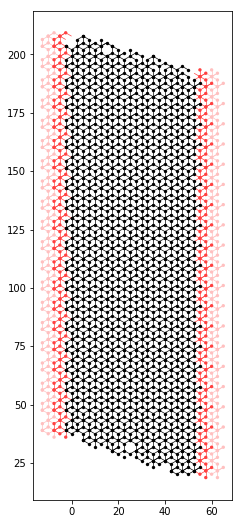

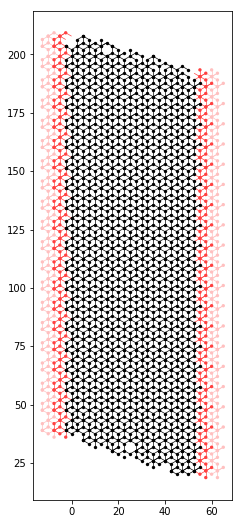

In [13]:
kwant.plot(system, fig_size=(16, 9))# site_color=edge_color)

### Find the coordinates of the lower edge sites, by first determining unique xvalues in site.pos and then determining the corresponding minimal yvalue


In [15]:
par = SimpleNamespace(t=1, eta=2.5, gamma1=0.4, B=0.0, v_sg=-0.6, v_bg=0.2, v_dis=0.2)

In [23]:
par = SimpleNamespace(t=1, eta=2.5, gamma1=0.4, B=0.0, v_sg=-0.6, v_bg=0.2)
#ldos = kwant.ldos(system, args=[par])

In [39]:
def calculate_conductance(sg, bg):
    par = SimpleNamespace(t=1, eta=2.5, gamma1=0.4, B=0.0, v_sg=sg, v_bg=bg, v_dis=0.0)
    smatrix = kwant.smatrix(system, energy=0.0, args=[par])
    return smatrix.transmission(1, 0)
    

In [38]:
vbg_values = [0.4,]#[0.2, 0.3, 0.4,]
vsg_values = np.linspace(-1, 0, 50)

In [25]:
conductances = {vbg: [calculate_conductance(vsg, vbg) for vsg in vsg_values] for vbg in vbg_values}

In [40]:
conductances_no_disorder = {
    vbg: [calculate_conductance(vsg, vbg) for vsg in vsg_values] for vbg in vbg_values}

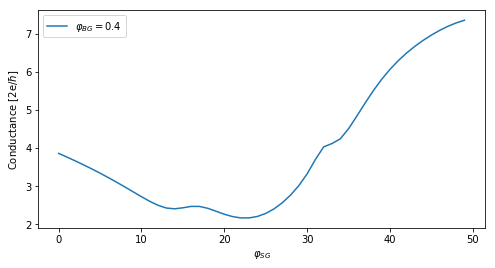

In [42]:
fig, ax = plt.subplots(figsize=(8,4))

for vbg in conductances_no_disorder:
    ax.plot(conductances_no_disorder[vbg], label=r'$\varphi_{{BG}} = {}$'.format(vbg))
    ax.legend()
    ax.set_xlabel(r'$\varphi_{{SG}}$')
    ax.set_ylabel('Conductance [2e/$\hbar$]')
#fig.savefig('QPC-conductance-decay={}.svg'.format(decay))